In [5]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

%matplotlib auto

Using matplotlib backend: TkAgg


In [2]:
df = pd.read_csv('6-2.csv', encoding='cp866', sep=';')[['Дата', 'Факт']].dropna()
df = df.rename({'Дата': 'Date', 'Факт':'Value'}, axis=1)
df['Value'] = df['Value'].astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Value
0,2000-04-14,14.384
1,2000-07-14,14.630
2,2000-10-13,15.601
3,2001-01-19,16.089
4,2001-04-13,13.854
...,...,...
74,2018-09-11,47.684
75,2019-11-02,57.537
76,2019-10-05,46.281
77,2019-09-08,39.541


Так данные покваратальные, очевидно предположить период сезонности 4 (1 год)

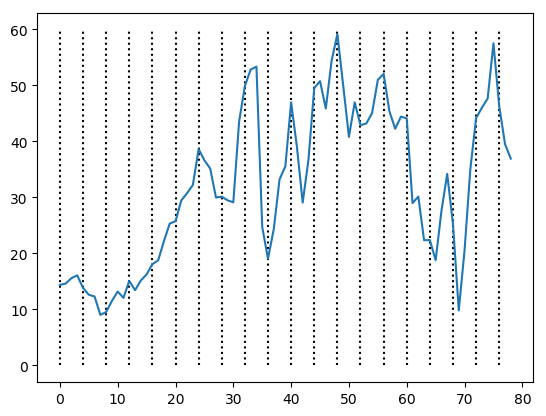

In [6]:
fig, ax = plt.subplots()
ax.vlines(x=[4 * i for i in range(20)], ymin=0, ymax=60, color='black', linestyle=':')
ax.plot(df['Value'])
fig

Сезонность не наблюдаем.

Так как в ряду присутствует очевидный тренд, дифференцируем ряд

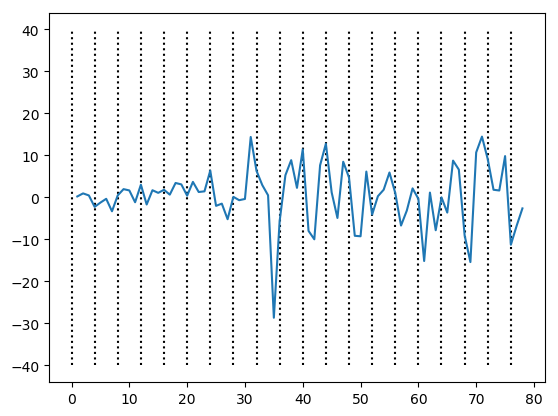

In [32]:
diff = df['Value'].diff().dropna()

fig, ax = plt.subplots()
ax.vlines(x=[4 * i for i in range(20)], ymin=-40, ymax=40, color='black', linestyle=':')
ax.plot(diff)
fig

Сезонность опять не очевидна

## Автокорреляция дифференцированного по сезону ряда

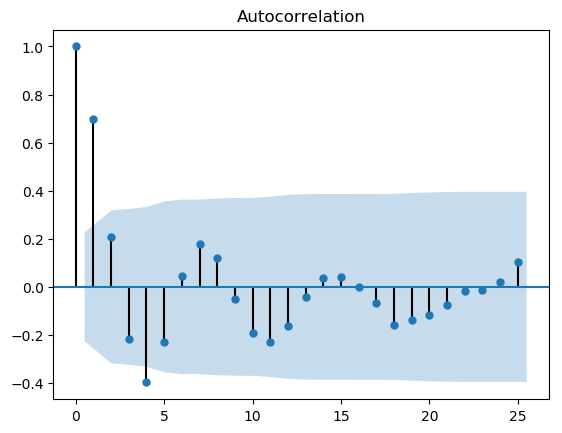

In [38]:
plot_acf(df['Value'].diff(4).dropna(), lags=25)

C:\Python36\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


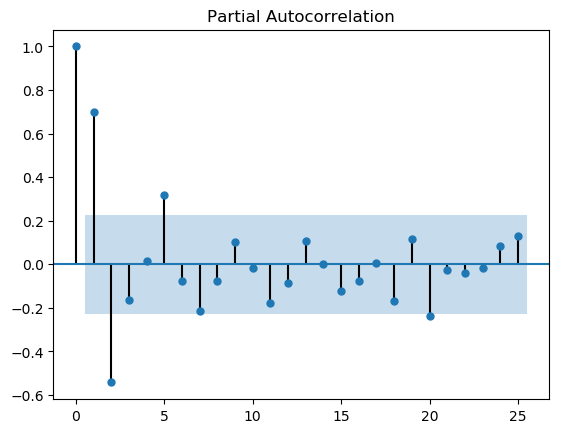

In [39]:
plot_pacf(df['Value'].diff(4).dropna(), lags=25, method='ywmle')

## Автокорреляция исходного ряда

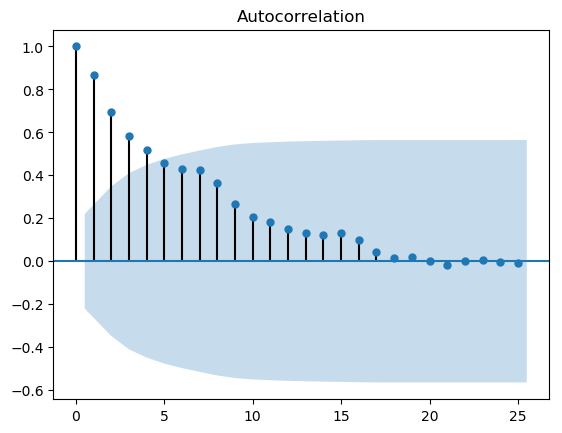

In [37]:
plot_acf(df['Value'], lags=25)

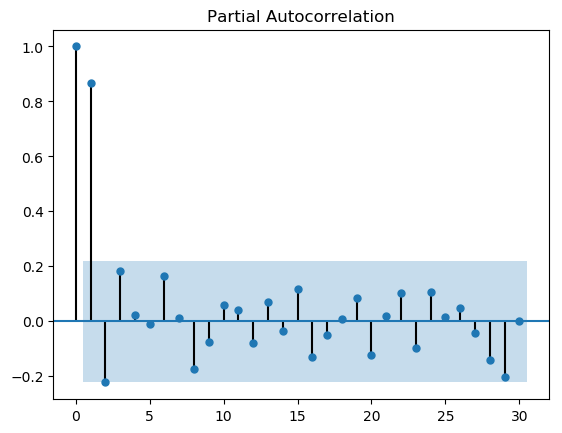

In [16]:
plot_pacf(df['Value'], lags=30, method='ywmle')

# SARIMA(1,1,0) (0,1,1,4)

In [66]:
model = ARIMA(df['Value'], order=(1,1,0), seasonal_order=(0,1,1,4))
model_res = model.fit()
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Value   No. Observations:                   79
Model:             ARIMA(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                -252.117
Date:                           Tue, 31 Mar 2020   AIC                            510.235
Time:                                   07:48:21   BIC                            517.147
Sample:                                        0   HQIC                           512.992
                                            - 79                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1795      0.127      1.410      0.159      -0.070       0.429
ma.S.L4       -0.8457      0.101     -8.344      0.000      -1.044      -0.647
sigma2        49.7936      6.200      8.031      0.000      37.641      61.946
===================================================================================
Ljung-Box (Q):                       46.05   Jarque-Bera (JB):                46.95
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               8.92   Skew:                            -1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

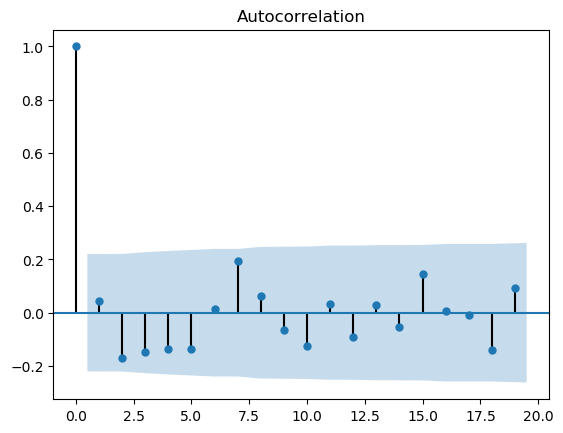

In [67]:
plot_acf(model_res.resid)

ACF выглядит нормально

In [68]:
ljungbox_df = acorr_ljungbox(model_res.resid, return_df=True, period=4)
ljungbox_df['Pr > 0.05'] = ljungbox_df['lb_pvalue'] > 0.05
ljungbox_df.dropna(inplace=True)
ljungbox_df

,lb_stat,lb_pvalue,Pr > 0.05
1,0.147008,0.701411,True
2,2.550829,0.279315,True
3,4.419188,0.219613,True
4,6.020302,0.197637,True
5,7.652590,0.176450,True
6,7.665940,0.263613,True
7,11.031556,0.137248,True
8,11.396823,0.180212,True


Как видно, тест Льюнг-Бокса показывает, что мы не можем отвергнуть нулевую гипотезу об отсутствии автокорреляции для первых 8 лагов

# SARIMA(1,1,2) (1,1,1,4)
Попробуем в этот раз использовать смешанную модель

In [61]:
model = ARIMA(df['Value'], order=(1,1,2), seasonal_order=(1,1,1,4))
model_res = model.fit()
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Value   No. Observations:                   79
Model:             ARIMA(1, 1, 2)x(1, 1, [1], 4)   Log Likelihood                -248.499
Date:                           Tue, 31 Mar 2020   AIC                            508.998
Time:                                   07:48:02   BIC                            522.822
Sample:                                        0   HQIC                           514.513
                                            - 79                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6484      0.228      2.846      0.004       0.202       1.095
ma.L1         -0.5447      0.268     -2.031      0.042      -1.070      -0.019
ma.L2         -0.3384      0.161     -2.108      0.035      -0.653      -0.024
ar.S.L4        0.0228      0.192      0.119      0.905      -0.353       0.398
ma.S.L4       -0.8530      0.150     -5.683      0.000      -1.147      -0.559
sigma2        43.9293      6.600      6.656      0.000      30.994      56.865
===================================================================================
Ljung-Box (Q):                       40.48   Jarque-Bera (JB):                42.35
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               8.02   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

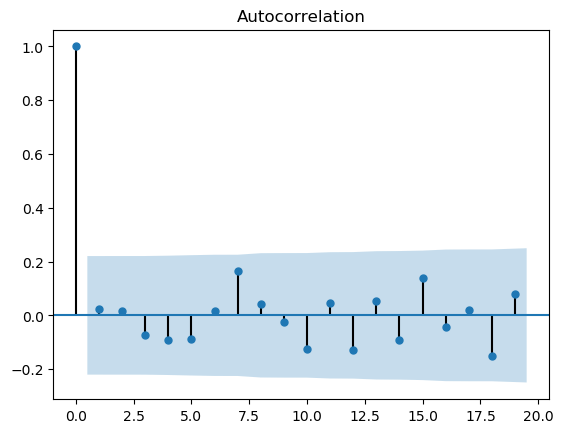

In [62]:
plot_acf(model_res.resid)

In [63]:
ljungbox_df = acorr_ljungbox(model_res.resid, return_df=True, period=4)
ljungbox_df['Pr > 0.05'] = ljungbox_df['lb_pvalue'] > 0.05
ljungbox_df.dropna(inplace=True)
ljungbox_df

,lb_stat,lb_pvalue,Pr > 0.05
1,0.042543,0.836589,True
2,0.065710,0.967679,True
3,0.536787,0.910738,True
4,1.274968,0.865608,True
5,1.921260,0.859929,True
6,1.944256,0.924753,True
7,4.335180,0.740463,True
8,4.501951,0.809238,True


Точно также, ACF выглядит нормально и тест Льинг-Бокса указывает на отсутсвие автокорреляции.

Однако эта модель имеет AIC=508, что меньше, поэтому можно сделать выбор в пользу этой модели